# 투자분석 hw4

20249433 최재필


alpha랑 market risk premium, 앞에서 구한 결과대로 값만 상수로 넣고 돌려보기. 

In [67]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm

import yfinance as yf

## (a)

- MSFT
- GOOG
- KO

Source: Yahoo Finance

In [68]:
START = '2015-01-01'
END = '2019-12-31'

In [69]:
MSFT = yf.Ticker("MSFT") # originally MSFT
GOOG = yf.Ticker("GOOG") # originally GOOGL
KO = yf.Ticker("KO") # originally KO

SPY = yf.Ticker("SPY")
Tbill3M = yf.Ticker("^IRX")

In [70]:
MSFT_df = MSFT.history(start=START, end=END, interval='1mo')
MSFT_ret = MSFT_df['Close'].pct_change().dropna()
MSFT_ret = MSFT_ret.rename('MSFT')

GOOG_df = GOOG.history(start=START, end=END, interval='1mo')
GOOG_ret = GOOG_df['Close'].pct_change().dropna()
GOOG_ret = GOOG_ret.rename('GOOG')

KO_df = KO.history(start=START, end=END, interval='1mo')
KO_ret = KO_df['Close'].pct_change().dropna()
KO_ret = KO_ret.rename('KO')

SPY_df = SPY.history(start=START, end=END, interval='1mo')
SPY_ret = SPY_df['Close'].pct_change().dropna()
SPY_ret = SPY_ret.rename('SPY')

Tbill3M_df = Tbill3M.history(start=START, end=END, interval='1mo')
Tbill3M_ret = Tbill3M_df['Close']
Tbill3M_ret = Tbill3M_ret.rename('Tbill3M')
Tbill3M_ret = Tbill3M_ret / 100 / 12 # convert to monthly rate

In [71]:
MSFT_ret.index = MSFT_ret.index.to_period('M')
GOOG_ret.index = GOOG_ret.index.to_period('M')
KO_ret.index = KO_ret.index.to_period('M')
SPY_ret.index = SPY_ret.index.to_period('M')
Tbill3M_ret.index = Tbill3M_ret.index.to_period('M')

Tbill3M_ret = Tbill3M_ret.reindex(MSFT_ret.index, method='ffill')

C:\Users\chlje\AppData\Local\Temp\ipykernel_70668\452896683.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  MSFT_ret.index = MSFT_ret.index.to_period('M')
C:\Users\chlje\AppData\Local\Temp\ipykernel_70668\452896683.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  GOOG_ret.index = GOOG_ret.index.to_period('M')
C:\Users\chlje\AppData\Local\Temp\ipykernel_70668\452896683.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  KO_ret.index = KO_ret.index.to_period('M')
C:\Users\chlje\AppData\Local\Temp\ipykernel_70668\452896683.py:4: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  SPY_ret.index = SPY_ret.index.to_period('M')
C:\Users\chlje\AppData\Local\Temp\ipykernel_70668\452896683.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  Tbill3M_ret.index 

In [72]:
df = pd.concat([MSFT_ret, GOOG_ret, KO_ret, SPY_ret, Tbill3M_ret], axis=1)
df = df.dropna()

In [73]:
# Make it excess return
excs_df = df.loc[:, ['MSFT', 'GOOG', 'KO', 'SPY']].subtract(df.loc[:, 'Tbill3M'], axis=0)
excs_df.columns = [f'{ticker}_excs' for ticker in excs_df.columns]
excs_df.tail()

,MSFT_excs,GOOG_excs,KO_excs,SPY_excs
Date,,,,
2019-08,0.010057,-0.025101,0.044180,-0.018354
2019-09,0.010370,0.024533,-0.012376,0.013297
2019-10,0.029968,0.032476,0.005878,0.025577
2019-11,0.054586,0.034309,-0.020207,0.034915
2019-12,0.044040,0.023314,0.043005,0.022767


## (b)

In [74]:
stocks = ['MSFT', 'GOOG', 'KO']

def get_SIM_regression(stock_returns, market_returns, print_summary=True):
    X = sm.add_constant(market_returns)
    model = sm.OLS(stock_returns, X)
    results = model.fit()

    if print_summary:
        print(results.summary())

    return results

각 종목의 초과수익률을 시장 초과수익률에 대해 regress

In [75]:
results = {}

for stock in stocks:
    print(f'SIM regression result of {stock}')
    results[stock] = get_SIM_regression(excs_df[f'{stock}_excs'], excs_df['SPY_excs'], print_summary=True)
    print('\n'*5)

SIM regression result of MSFT
                            OLS Regression Results                            
Dep. Variable:              MSFT_excs   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.470
Method:                 Least Squares   F-statistic:                     52.38
Date:                Wed, 05 Jun 2024   Prob (F-statistic):           1.28e-09
Time:                        06:11:59   Log-Likelihood:                 103.09
No. Observations:                  59   AIC:                            -202.2
Df Residuals:                      57   BIC:                            -198.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0151 

In [76]:
def get_result_values(single_stock_result):
    alpha, beta = single_stock_result.params
    t_value_alpha, t_value_beta = single_stock_result.tvalues
    p_value_alpha, p_value_beta = single_stock_result.pvalues
    r_squared = single_stock_result.rsquared

    # residual std는 따로 계산해야 함
    residuals = single_stock_result.resid
    resid_df = single_stock_result.df_resid
    residual_std = np.sqrt( (residuals**2).sum() / resid_df )

    result_values = {
        'alpha': alpha,
        'beta': beta,
        't_value_alpha': t_value_alpha,
        't_value_beta': t_value_beta,
        'p_value_alpha': p_value_alpha,
        'p_value_beta': p_value_beta,
        'r_squared': r_squared,
        'residual_std': residual_std
    }

    return result_values


In [77]:
msft_result_values = get_result_values(results['MSFT'])
goog_result_values = get_result_values(results['GOOG'])
ko_result_values = get_result_values(results['KO'])


In [78]:
msft_result_values

{'alpha': 0.01506599388754327,
 'beta': 1.1523082415604675,
 't_value_alpha': 2.6046102034342935,
 't_value_beta': 7.237495402414416,
 'p_value_alpha': 0.011709990999620883,
 'p_value_beta': 1.2789403205909553e-09,
 'r_squared': 0.4788873480947523,
 'residual_std': 0.042892658090208355}

In [79]:
goog_result_values

{'alpha': 0.006448675204730689,
 'beta': 1.0541924211363984,
 't_value_alpha': 1.0502582392266726,
 't_value_beta': 6.237637975867893,
 'p_value_alpha': 0.2980319574564877,
 'p_value_beta': 5.8526907686235904e-08,
 'r_squared': 0.40568123395685496,
 'residual_std': 0.04553048932340449}

In [80]:
ko_result_values

{'alpha': 0.003728367088568274,
 'beta': 0.404065985811099,
 't_value_alpha': 0.8357804916003417,
 't_value_beta': 3.2907928077250173,
 'p_value_alpha': 0.4067683041763813,
 'p_value_beta': 0.001717408234378,
 'r_squared': 0.1596554076305865,
 'residual_std': 0.03307915043491735}

## (c)

In [81]:
mkt_excs_mean = excs_df['SPY_excs'].mean() # Market expected return
mkt_excs_std = excs_df['SPY_excs'].std() # Market expected volatility

In [82]:
ann_mkt_excs_mean = mkt_excs_mean * 12
ann_mkt_excs_std = mkt_excs_std * np.sqrt(12)

In [83]:
betas = np.array([msft_result_values['beta'], goog_result_values['beta'], ko_result_values['beta']])
betas

array([1.15230824, 1.05419242, 0.40406599])

In [84]:
msft_excs_std = excs_df['MSFT_excs'].std()
goog_excs_std = excs_df['GOOG_excs'].std()
ko_excs_std = excs_df['KO_excs'].std()

excs_stds = np.array([msft_excs_std, goog_excs_std, ko_excs_std])
excs_stds

array([0.05890343, 0.05854853, 0.03577248])

In [85]:
ann_excs_stds = excs_stds * np.sqrt(12)

In [86]:
sys_stds = betas * ann_mkt_excs_std
sys_stds

array([0.14120429, 0.12918114, 0.0495144 ])

In [87]:
resid_stds = np.sqrt(ann_excs_stds**2 - sys_stds**2)
resid_stds

array([0.14729806, 0.15635666, 0.1135974 ])

In [88]:
# alphas = [0.02, -0.01, 0.01] # already annualized
alphas = [ 0.10675492,  0.10936121, -0.06044151]


In [89]:
# ANN_MKT_RISKPREMIUM = 0.06
ANN_MKT_RISKPREMIUM = 0.1109

riskpremiums = ANN_MKT_RISKPREMIUM * betas
riskpremiums

array([0.12779098, 0.11690994, 0.04481092])

### 교수님 엑셀처럼 값 정리하여 optimal risky portfolio 구하기

#### $ \sigma^2(\epsilon_i) $ 

In [90]:
resid_vars = resid_stds**2
resid_vars

array([0.02169672, 0.0244474 , 0.01290437])

#### $ \alpha_i / \sigma^2(\epsilon_i) $

In [91]:
alpha_div_resid_vars = alphas / resid_vars
alpha_div_resid_vars

array([ 4.92032591,  4.47332614, -4.68380174])

#### $ w_i $

In [92]:
weights = alpha_div_resid_vars / alpha_div_resid_vars.sum()
weights

array([ 1.04468838,  0.94978096, -0.99446934])

In [93]:
np.round(weights.sum(), 10)

1.0

#### $ \alpha_A $

In [94]:
weighted_alpha = weights @ alphas
weighted_alpha

0.2755020481585262

#### $ \beta_A $

In [95]:
weighted_beta = weights @ betas
weighted_beta

1.8032236865501876

#### $ \sigma^2(\epsilon_A) $ - residual variance

In [96]:
active_residual_var = weights**2 @ resid_vars
active_residual_var

0.05849486285953748

#### $ \sigma_A^2 $ - active portfolio variance


In [97]:
active_port_var = weighted_beta**2 * ann_mkt_excs_std**2 + active_residual_var
active_port_var

0.10732159357814494

#### $ w_A^0 $

In [98]:
w_A_0 = (weighted_alpha / active_residual_var) / (mkt_excs_mean / mkt_excs_std**2) # 여기서 lookahead std로 넣었다. 원래는 historical 쓰던데.
w_A_0

0.6219740223594964

#### $ w_A^* $

In [99]:
w_A_star = w_A_0 / (1 + w_A_0 * (1 - weighted_beta))
w_A_star

1.2429146039275094

개별 주식 weight

In [100]:
final_weights = w_A_star * weights
final_weights

array([ 1.29845845,  1.18049662, -1.23604047])

#### $ w_M^* $

In [101]:
w_M_star = 1 - w_A_star
w_M_star

-0.2429146039275094

### 그래프 확인

In [102]:
final_weights

array([ 1.29845845,  1.18049662, -1.23604047])

<Axes: xlabel='Date'>

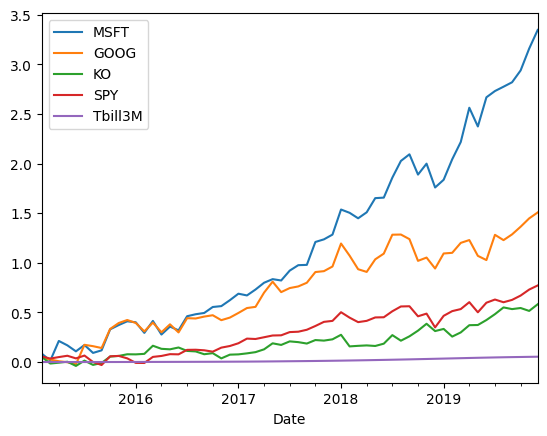

In [103]:
((1 + df).cumprod() - 1).plot()

In [104]:
final_alpha = final_weights @ alphas
final_alpha

0.3424255190681722

In [105]:
final_std = np.sqrt(final_weights @ resid_vars)
final_std

0.20268704925581826

## (d)

Information ratio

In [106]:
information_ratio = final_alpha / final_std
information_ratio

1.6894296913661475

## (e)

In [107]:
active_riskpremium = final_weights @ riskpremiums
active_riskpremium

0.24855496370648034

In [108]:
optimal_riskpremium = ANN_MKT_RISKPREMIUM * w_M_star + active_riskpremium * w_A_star
optimal_riskpremium

0.2819933646938957

In [109]:
market_sharpe = ANN_MKT_RISKPREMIUM / ann_mkt_excs_std
market_sharpe

0.9050078087776795

In [110]:
optimal_sharpe = np.sqrt(market_sharpe ** 2 + information_ratio ** 2)
optimal_sharpe

1.9165624998987363